# **imports**

In [117]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.datasets import cifar10, mnist
from keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense,
                          Dropout, Flatten, Input, Reshape, UpSampling2D,
                          ZeroPadding2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
# from tensorflow.keras.optimizers import Adamifar10
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds

%matplotlib inline

# **initialization and loading Data**

In [118]:
# Consistent results
np.random.seed(10)

# The dimension of z
noise_dim = 100

batch_size = 128
steps_per_epoch = 64 
epochs = 60

save_path = 'fcgan-images'

img_rows, img_cols, channels = 32, 32, 3

optimizer = Adam(0.0002, 0.5)

In [119]:
# Create path for saving images
if save_path != None and not os.path.isdir(save_path):
    os.mkdir(save_path)

In [120]:
#-- Load DS--
(train_examples), info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'))

dataset = tfds.as_numpy(train_examples)

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


def resize(img):
  # img = tf.cast(img, tf.float32)
  img = tf.image.resize(img, (img_rows, img_cols))
  # img = tf.cast(img, tf.float32)
  # img = (img / 127.5) -1
  return img

x_train = np.zeros(shape=(8192,img_rows, img_cols,3))
i = 0 
for i,x in enumerate(dataset) :
  if i <8192:
    image = resize((x['image']))
    # print(image.shape)
    # print(image)
    # plt.imshow(image.reshape((img_rows, img_cols, channels)))
    # plt.show()
    x_train[i] = image

  i+=1
  if i >8192:
    break

# Normalize to between -1 and 1
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

x_train = x_train.reshape(-1, img_rows*img_cols*channels)

In [121]:
x_train.shape

(8192, 3072)

# **create generator and Discriminator**

In [122]:
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(2048, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))


    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def create_descriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(2048, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator



# **Noise**

In [123]:
import random 

#-- Show Noisy DS--------------------------------------------------------------
def Show_Noisy_DS(data, size_fig):
    index_list = np.random.randint(data.shape[0],
                                   size= size_fig[0] * size_fig[1])
    plt.figure(figsize=size_fig)

    for i in range(size_fig[0] * size_fig[1]):
        image = data[index_list[i],:]
        plt.subplot(size_fig[0], size_fig[1], i+1)
        # plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        # plt.imshow((image.reshape((img_rows, img_cols, channels))*255).astype(np.uint8))
        # plt.imshow(((image.reshape((img_rows, img_cols, channels))*127.5)+127.5).astype(np.uint8))
        # image = np.clip(image, a_min = 0, a_max =255)
        # print(image)
        plt.imshow((image.reshape((img_rows, img_cols, channels))))

        plt.axis('off')
    plt.show()


#--Add Noide to data with probability p----------------------------------------
def Add_Noise(data , p):
    
    noisy_data = np.copy(data)
    
    #number of pixels = data.shape[1]
    number_of_noisy_pixels = int(p * data.shape[1])
    print("####" ,number_of_noisy_pixels)

    # number of images = data.shape[0]
    for i in range(noisy_data.shape[0]):
        
        # create random index in 0 - 784(data.shape[1])
        index_of_noisy_pixels = np.random.randint(data.shape[1],
                                                  size = (number_of_noisy_pixels))         

        for j in range(number_of_noisy_pixels):
            noisy_pixel = random.randint(0,256)
            row = i # data i
            col = index_of_noisy_pixels[j]
            noisy_data[row,col] = noisy_pixel
    
    return noisy_data

# **make model**

In [124]:
discriminator = create_descriminator()
generator = create_generator()

# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
discriminator.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

# **add noise to data**

#### 0


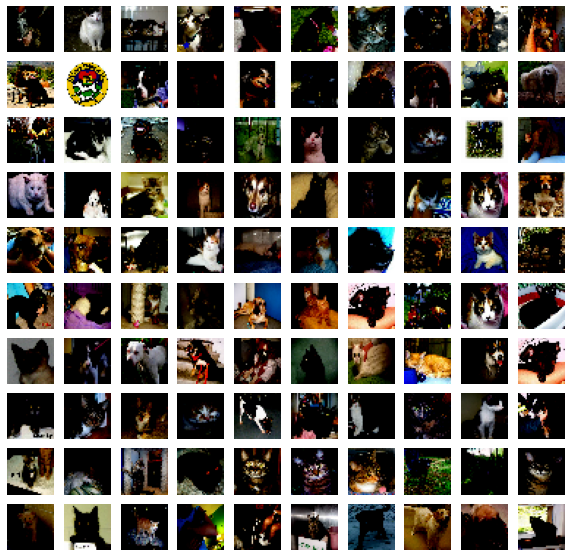

(8192, 3072)


In [125]:
# -- Add Noise--
p = 0
X_train_noisy = Add_Noise(x_train , p)
x_train = X_train_noisy


Show_Noisy_DS(data= x_train, size_fig=(10,10))
 
#-- Normalization to [-1,1]--
# x_train = (x_train.astype(np.float32) - 127.5) / 127.

#-- Reshape Images      
# x_train = x_train.reshape(-1, img_rows, img_cols, channels)  
# x_train = x_train.reshape(-1, img_rows*img_cols*channels)
print(x_train.shape)

In [126]:
# Display images, and save them if the epoch number is specified
def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    
    if epoch != None and save_path != None:
        plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
    plt.show()

In [127]:
#-- Plot Losses----------------------------------------------------------------
def Plot_Loss(d_losses, g_losses):
    
    d_losses = np.round(d_losses , 3)
    d_losses = np.round(d_losses , 3)
    
    x_plot = range(1, len(d_losses)+1)
    
    plt.figure(figsize=(7,4))
    
    plt.scatter(x=x_plot, y=d_losses)
    plt.plot(x_plot, d_losses , label= 'discriminator')
    
    plt.scatter(x=x_plot, y=g_losses)
    plt.plot(x_plot , g_losses, label = 'generator')
    
    
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.grid()
    plt.show()

# **Train and show results**

Epoch: 0 	 Discriminator Loss: 0.4892663359642029 		 Generator Loss: 1.0631338357925415


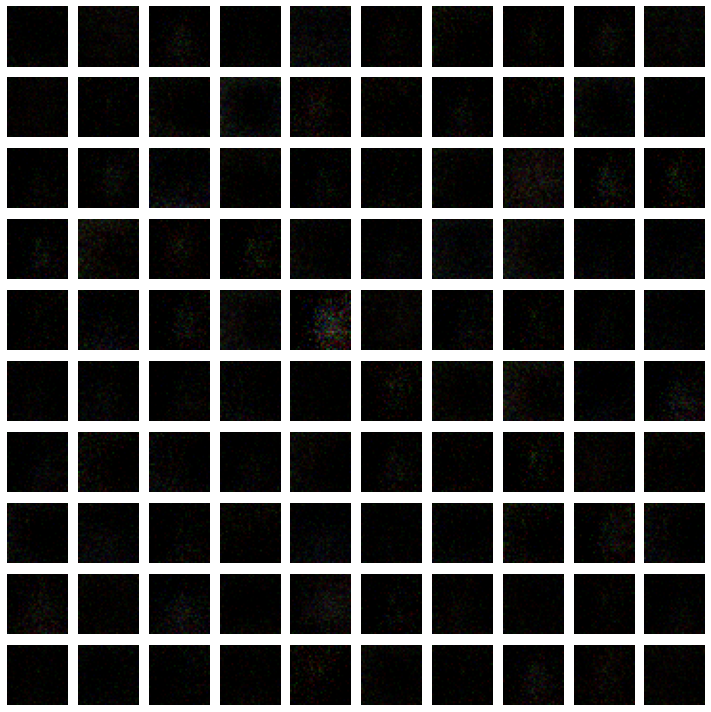

Epoch: 1 	 Discriminator Loss: 0.42402929067611694 		 Generator Loss: 1.5886099338531494
Epoch: 2 	 Discriminator Loss: 0.43701836466789246 		 Generator Loss: 1.61940598487854
Epoch: 3 	 Discriminator Loss: 0.47684288024902344 		 Generator Loss: 1.9603275060653687
Epoch: 4 	 Discriminator Loss: 0.7512659430503845 		 Generator Loss: 1.450448751449585
Epoch: 5 	 Discriminator Loss: 0.46161895990371704 		 Generator Loss: 2.0555427074432373
Epoch: 6 	 Discriminator Loss: 0.5221927165985107 		 Generator Loss: 1.9038398265838623
Epoch: 7 	 Discriminator Loss: 0.4564942419528961 		 Generator Loss: 1.9833228588104248
Epoch: 8 	 Discriminator Loss: 0.45574846863746643 		 Generator Loss: 2.0160343647003174
Epoch: 9 	 Discriminator Loss: 0.5145625472068787 		 Generator Loss: 1.9675254821777344


Epoch: 10 	 Discriminator Loss: 0.5127653479576111 		 Generator Loss: 1.8959591388702393


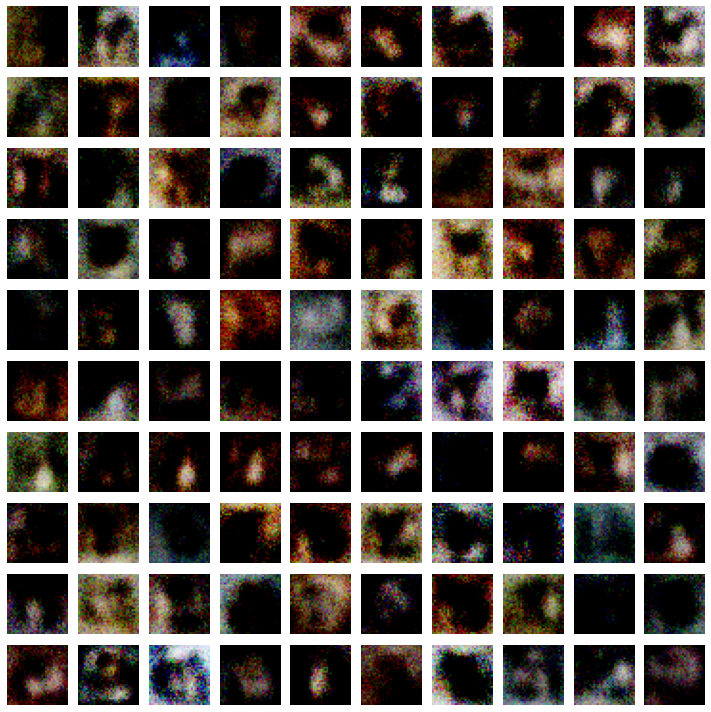

Epoch: 11 	 Discriminator Loss: 0.4658318758010864 		 Generator Loss: 2.6339669227600098
Epoch: 12 	 Discriminator Loss: 0.48662203550338745 		 Generator Loss: 2.0836360454559326
Epoch: 13 	 Discriminator Loss: 0.5272958278656006 		 Generator Loss: 2.1408281326293945
Epoch: 14 	 Discriminator Loss: 0.5302802920341492 		 Generator Loss: 1.9308571815490723
Epoch: 15 	 Discriminator Loss: 0.4667753577232361 		 Generator Loss: 1.888741374015808
Epoch: 16 	 Discriminator Loss: 0.5293561816215515 		 Generator Loss: 1.4026612043380737
Epoch: 17 	 Discriminator Loss: 0.472781777381897 		 Generator Loss: 2.292802572250366
Epoch: 18 	 Discriminator Loss: 0.5324634313583374 		 Generator Loss: 2.063340663909912
Epoch: 19 	 Discriminator Loss: 0.530043363571167 		 Generator Loss: 2.429755210876465


Epoch: 20 	 Discriminator Loss: 0.5782246589660645 		 Generator Loss: 2.6835083961486816


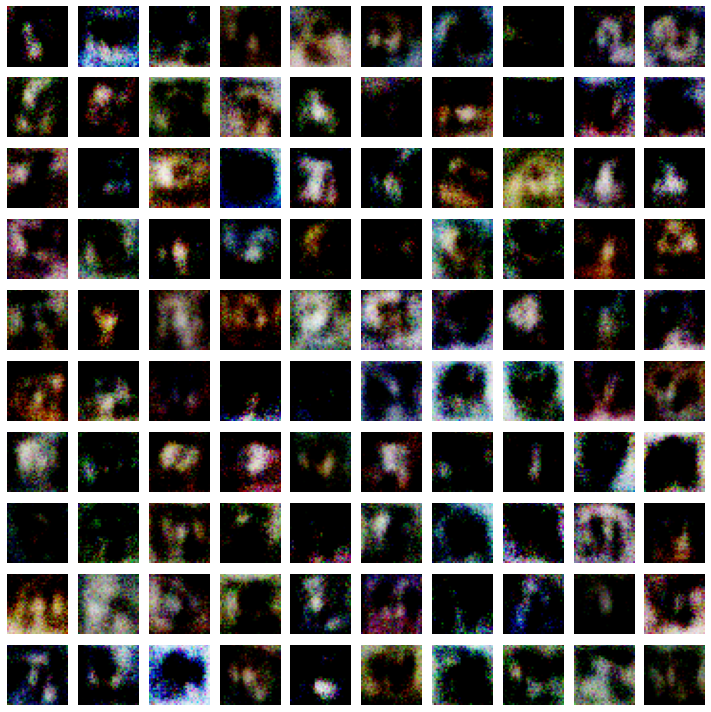

Epoch: 21 	 Discriminator Loss: 0.5430271029472351 		 Generator Loss: 1.8860890865325928
Epoch: 22 	 Discriminator Loss: 0.4854419529438019 		 Generator Loss: 1.8385387659072876
Epoch: 23 	 Discriminator Loss: 0.585342526435852 		 Generator Loss: 1.8781044483184814
Epoch: 24 	 Discriminator Loss: 0.5338982343673706 		 Generator Loss: 2.314633846282959
Epoch: 25 	 Discriminator Loss: 0.4673651158809662 		 Generator Loss: 2.2430100440979004
Epoch: 26 	 Discriminator Loss: 0.5481023788452148 		 Generator Loss: 1.9053027629852295
Epoch: 27 	 Discriminator Loss: 0.5930365920066833 		 Generator Loss: 1.8667488098144531
Epoch: 28 	 Discriminator Loss: 0.4964711666107178 		 Generator Loss: 2.1593196392059326
Epoch: 29 	 Discriminator Loss: 0.44842633605003357 		 Generator Loss: 2.0851988792419434


Epoch: 30 	 Discriminator Loss: 0.5480161905288696 		 Generator Loss: 2.4569554328918457


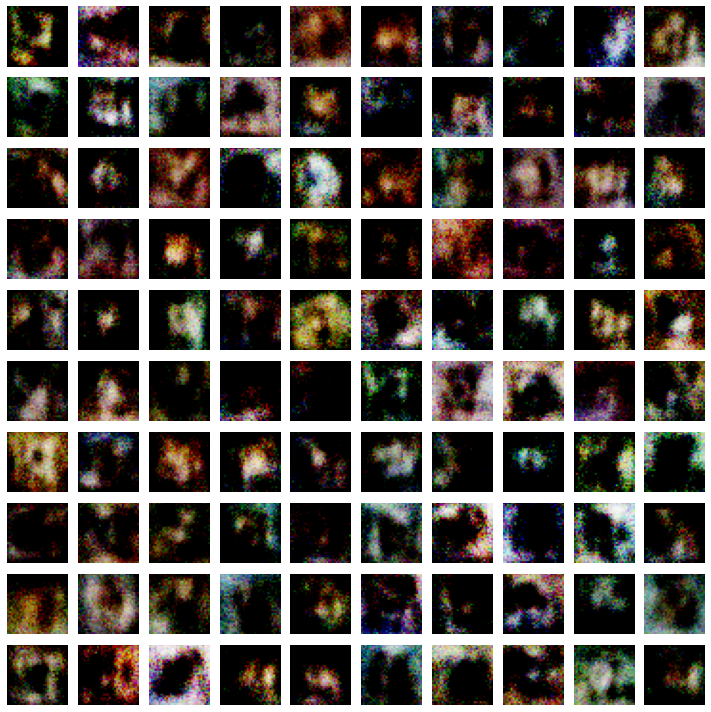

Epoch: 31 	 Discriminator Loss: 0.5942478179931641 		 Generator Loss: 1.7458990812301636
Epoch: 32 	 Discriminator Loss: 0.62236088514328 		 Generator Loss: 2.819329261779785
Epoch: 33 	 Discriminator Loss: 0.4967752695083618 		 Generator Loss: 1.7935655117034912
Epoch: 34 	 Discriminator Loss: 0.4811194837093353 		 Generator Loss: 2.324613094329834
Epoch: 35 	 Discriminator Loss: 0.6000638008117676 		 Generator Loss: 2.018749952316284
Epoch: 36 	 Discriminator Loss: 0.47248902916908264 		 Generator Loss: 2.147473096847534
Epoch: 37 	 Discriminator Loss: 0.4690564274787903 		 Generator Loss: 2.3973240852355957
Epoch: 38 	 Discriminator Loss: 0.5109699368476868 		 Generator Loss: 2.0575294494628906
Epoch: 39 	 Discriminator Loss: 0.5766896605491638 		 Generator Loss: 2.3697917461395264


Epoch: 40 	 Discriminator Loss: 0.5221743583679199 		 Generator Loss: 1.6273393630981445


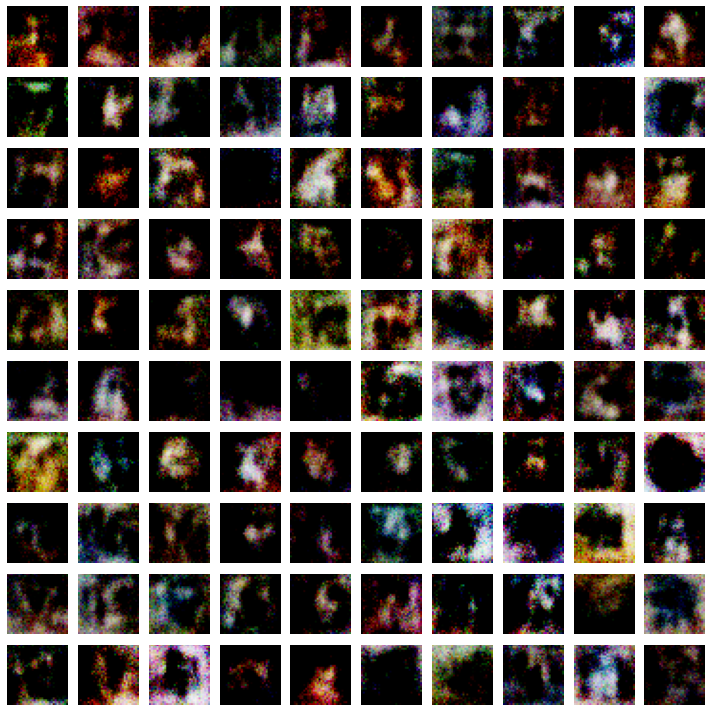

Epoch: 41 	 Discriminator Loss: 0.5178045630455017 		 Generator Loss: 1.4906425476074219
Epoch: 42 	 Discriminator Loss: 0.49450263381004333 		 Generator Loss: 2.059730291366577
Epoch: 43 	 Discriminator Loss: 0.4860800802707672 		 Generator Loss: 2.006216287612915
Epoch: 44 	 Discriminator Loss: 0.5007491111755371 		 Generator Loss: 1.8078944683074951
Epoch: 45 	 Discriminator Loss: 0.6384364366531372 		 Generator Loss: 1.3812376260757446
Epoch: 46 	 Discriminator Loss: 0.5220078825950623 		 Generator Loss: 1.6176538467407227
Epoch: 47 	 Discriminator Loss: 0.5107575058937073 		 Generator Loss: 1.7633233070373535
Epoch: 48 	 Discriminator Loss: 0.5438596606254578 		 Generator Loss: 2.0879478454589844
Epoch: 49 	 Discriminator Loss: 0.5762239098548889 		 Generator Loss: 2.479384660720825


Epoch: 50 	 Discriminator Loss: 0.5659196376800537 		 Generator Loss: 1.8907743692398071


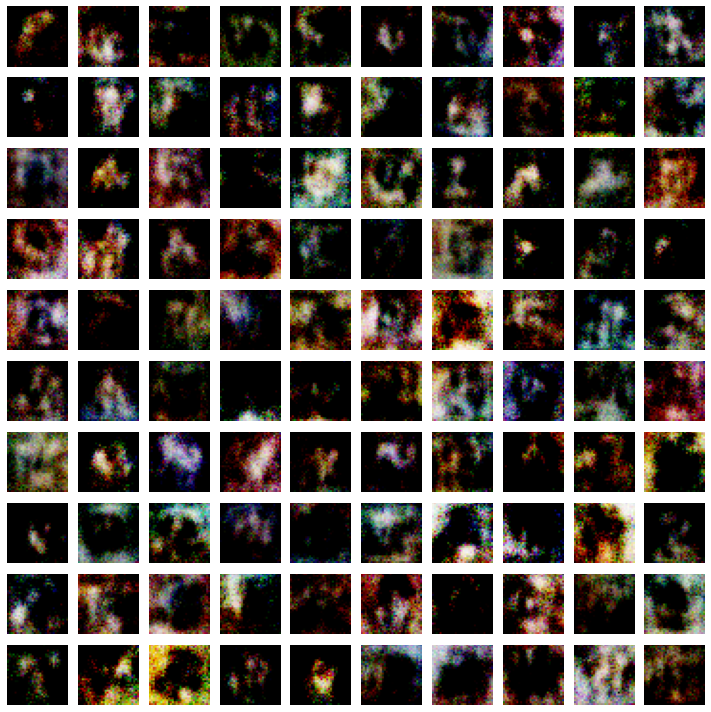

Epoch: 51 	 Discriminator Loss: 0.5069465041160583 		 Generator Loss: 1.9538277387619019
Epoch: 52 	 Discriminator Loss: 0.5031408667564392 		 Generator Loss: 2.1063895225524902
Epoch: 53 	 Discriminator Loss: 0.5165561437606812 		 Generator Loss: 2.013051986694336
Epoch: 54 	 Discriminator Loss: 0.4961956739425659 		 Generator Loss: 1.62577223777771
Epoch: 55 	 Discriminator Loss: 0.5710113048553467 		 Generator Loss: 2.7916247844696045
Epoch: 56 	 Discriminator Loss: 0.5415486693382263 		 Generator Loss: 1.9815975427627563
Epoch: 57 	 Discriminator Loss: 0.515129804611206 		 Generator Loss: 2.120655059814453
Epoch: 58 	 Discriminator Loss: 0.5457255840301514 		 Generator Loss: 1.7982755899429321
Epoch: 59 	 Discriminator Loss: 0.4978276789188385 		 Generator Loss: 2.015277147293091


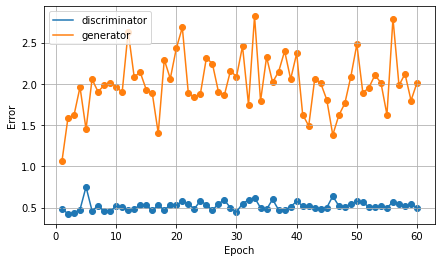

In [128]:
#-- Train --
d_losses = []
g_losses = []

# Constant noise for viewing how the GAN progresses
static_noise = np.random.normal(0, 1, size=(100, noise_dim))

for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)
        # print(fake_x.shape)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        # real_x = real_x.reshape(-1, img_rows*img_cols*channels)  

        
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    d_losses.append(d_loss)
    g_losses.append(g_loss)
    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    if epoch % 10 == 0:
        show_images(static_noise, epoch)
        
Plot_Loss(d_losses, g_losses)